# Cellpose program. 

This is a program used to generate a new cellpose model based on a series of representative images and their corresponding labelled images. 

In [1]:
from cellpose import core, models, io, metrics

import os

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import tqdm 
import tifffile as tf

import tqdm
import tkinter as tk
from tkinter import filedialog


from PIL import Image

import datetime

-------
### Write in cell type

In [2]:
cell_type = '_Abhi_cells_circs'

### set the Folder path for the test images

In [3]:
root = tk.Tk()
root.withdraw() # Stops a second window opening
image_folder = filedialog.askdirectory(title = 'Select image Folder')

### Set the folder path for the user defined masks

In [4]:
root = tk.Tk()
root.withdraw() # Stops a second window opening
mask_folder = filedialog.askdirectory(title = 'Select Masks Folder')

--------------
## Create a method to extract all the filenames from a folder. 

In [5]:
def get_files_from_folder(folder_path): 
    '''A method to extract all files from the image.'''

    file_list = os.listdir(folder_path)
    image_files = []
    
    for i in range( len(file_list) ): 
        if file_list[i][-4:] == '.tif' or file_list[i][-4:] == '.png':
            image_files.append(file_list[i])
        
    return(image_files)

----
## Create a method to download in the image data from the image file name. 

In [6]:
def get_image_data(image_file):
    '''Get the image data from the file using Pillow.
    Convert the PILLOW image to a numpy array'''

    image_data = tf.imread(image_file)
    
    # print(image_data.getexif())
    
    np_image_data = np.array(image_data)

    return(np_image_data)

-----
## Collect the image files from folder. 

In [7]:
image_file_list = get_files_from_folder(image_folder)
mask_file_list = get_files_from_folder(mask_folder)


print(image_folder)
print(mask_folder)
print( len(image_file_list) )
print( len(mask_file_list) )


//data.beatson.gla.ac.uk/data/RCORBYN/User_Data/Current Projects/20240411_Abhi/20240604_QuPath_circles/ground_truth/_images
//data.beatson.gla.ac.uk/data/RCORBYN/User_Data/Current Projects/20240411_Abhi/20240604_QuPath_circles/ground_truth/_masks
117
117


----
## extract datasets for testing/training

In [8]:
training_image_index = np.random.choice(len(image_file_list)-1, size = int(0.8*(len(image_file_list)-1)), replace = False)

print('Training image Files :' + str(np.sort(training_image_index)) )
print('Number of training Images: ' + str(len(training_image_index)))

# Create test image index. 
test_image_index = []

for i in range(len(image_file_list)):
    if len(np.where(training_image_index == i)[0]) == 0:
        test_image_index.append(i)

print('Validation image files :' + str(test_image_index) )
print('Number of Validation Images: ' + str(len(test_image_index)) )

Training image Files :[  0   1   2   3   4   5   6   9  10  11  13  14  15  17  18  19  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  41
  42  43  45  46  47  48  49  51  53  54  55  56  57  58  61  62  63  66
  67  68  69  70  71  72  73  74  75  76  77  79  80  81  84  85  86  88
  90  91  92  94  96  97  98 100 102 103 104 105 106 107 108 109 110 113
 114 115]
Number of training Images: 92
Validation image files :[7, 8, 12, 16, 20, 40, 44, 50, 52, 59, 60, 64, 65, 78, 82, 83, 87, 89, 93, 95, 99, 101, 111, 112, 116]
Number of Validation Images: 25


--------
## Get test images and user_masks into a format for cellpose model Training. 

In [9]:
# Initialise 
ground_truth_training = []
training_images = []

for i in range(len(training_image_index)):
    # get the image data
    image_file_name = image_file_list[training_image_index[i]]
    individual_image = get_image_data(image_folder + '/'+ image_file_name)
    training_images.append(individual_image)
    # get the corresponding user_defined_mask
    mask_file_name = image_file_name[0:-4] + '.tif'
    # print(image_file_name)
    # print(mask_file_name)
    user_mask = get_image_data(mask_folder + '/'+ mask_file_name)
    ground_truth_training.append(user_mask)

    
# ground_truth = np.array(ground_truth)
print(training_images[0].shape)
print(ground_truth_training[0].shape)
print(len(training_images))

(65, 62)
(65, 62)
92


-----
## Get test images and user_masks into a format for cellpose model evaluation. 

In [10]:
ground_truth_test = []
test_images = []

for i in range(len(test_image_index)):
    # get the image data
    image_file_name = image_file_list[test_image_index[i]]
    individual_image = get_image_data(image_folder + '/'+ image_file_name)
    test_images.append(individual_image)
    # get the corresponding user_defined_mask
    mask_file_name = image_file_name[0:-4] + '.tif'
    # print(image_file_name)
    # print(mask_file_name)
    user_mask = get_image_data(mask_folder + '/'+ mask_file_name)
    ground_truth_test.append(user_mask)

    
# ground_truth = np.array(ground_truth)
print(test_images[i].shape)
print(ground_truth_test[i].shape)
print(len(test_images))

(100, 105)
(100, 105)
25


---------
### Create a meta_data file

In [27]:
def save_metadata():
    '''Save the training parameters for the deep learning model.  '''

    meta_data = pd.DataFrame({'model_name': [model_name], 
                              'Number of Training Images': [num_training_ims], 
                              'Number of Test Images': [num_testing_ims], 
                              'Number of Epochs': [n_epochs],  
                              'Learning Rate for training': [learning_rate], 
                              'Weight Decay for training': [weight_decay], 
                              'Training data split': [training_data_split], 
                              'Validation data split': [1 - training_data_split], 
                              'Number of images per epoch': [ims_per_epoch], 
                              'Model from the zoo': [start_model], 
                              'Model Accuracy': [ap[:,0].mean()]})
    
    meta_data.to_csv(
                    os.path.dirname(image_folder) + '/models/' + model_name + '_meatadata.csv')

--- 

---
## I will attempt to train a model on the training datasets. 

In [19]:
# This cell is taken directly from the Colab notebook and then 
# modified for my needs. 

# Get the time and date for the mask name. 
date_time_vals = str(datetime.datetime.now())

date = date_time_vals[0:10].replace('-', '_')

point_find = date_time_vals.find('.')
time = date_time_vals[11:point_find].replace(':', '_')

start_model = 'cyto'

# start logger (to see training across epochs)
logger = io.logger_setup()

# set channels
channels = [0, 0]

n_epochs = 100

learning_rate = 0.1

weight_decay = 0.0001

ims_per_epoch = 8

training_data_split = 0.8

num_training_ims = int(training_data_split * len(training_images)) 

num_testing_ims = len(training_images) - int(training_data_split * len(training_images)) 

model_name =  date + '_' + time + '_' + cell_type 

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=True, model_type=start_model)
# model = openvino_utils.to_openvino(model)

test_files2 = list(test_images)
test_masks2 = list(ground_truth_test)

new_model_path = model.train(training_images[0 : num_training_ims ], ground_truth_training[0 : num_training_ims ], 
                              test_data=training_images[num_training_ims:],
                              test_labels=ground_truth_training[num_training_ims:],
                              channels=channels, 
                              save_path=os.path.dirname(image_folder), 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              nimg_per_epoch=ims_per_epoch,
                              model_name = model_name )

# diameter of labels in training images
diam_labels = model.diam_labels.copy()

print(test_images[0].shape)

2024-06-05 15:53:23,684 [INFO] WRITING LOG OUTPUT TO C:\Users\rcorbyn\.cellpose\run.log


In [28]:
retrained_masks = []

model_path = 'C:/Users/rcorbyn/.cellpose/models/' + '2024_06_05_14_36_50__Abhi_cells_circs'
model_name = '2024_06_05_14_36_50__Abhi_cells_circs'
print(model_path)

# declare model
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

for i in tqdm.tqdm(range(len(test_images) )):
    masks = model.eval(test_images[i], channels = [0, 0], diameter = None)[0]
    retrained_masks.append(masks)

# Check the performance of the model using IoU metric. 
ap = metrics.average_precision(ground_truth_test, retrained_masks)[0]
print(ap[:,0].mean()) 

save_metadata()

C:/Users/rcorbyn/.cellpose/models/2024_06_05_14_36_50__Abhi_cells_circs
2024-06-05 15:57:02,288 [INFO] >>>> loading model C:/Users/rcorbyn/.cellpose/models/2024_06_05_14_36_50__Abhi_cells_circs
2024-06-05 15:57:02,288 [INFO] TORCH CUDA version not installed/working.
2024-06-05 15:57:02,288 [INFO] >>>> using CPU
2024-06-05 15:57:02,405 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-05 15:57:02,405 [INFO] >>>> model diam_labels =  12.008 (mean diameter of training ROIs)


 84%|██████████████████████████████████████████▊        | 21/25 [00:14<00:03,  1.19it/s]

2024-06-05 15:57:17,755 [INFO] No cell pixels found.


100%|███████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.41it/s]


0.7492223


In [14]:
for i in range( len(test_image_index) ):
    print(image_file_list[test_image_index[i]])

Training_image_XR175_G11_00.tif
Training_image_XR175_G11_03.tif
Training_image_XR175_G11_07.tif
Training_image_XR175_G11_08.tif
Training_image_XR175_H12_19.tif


Text(0.5, 1.0, 'Ground truth')

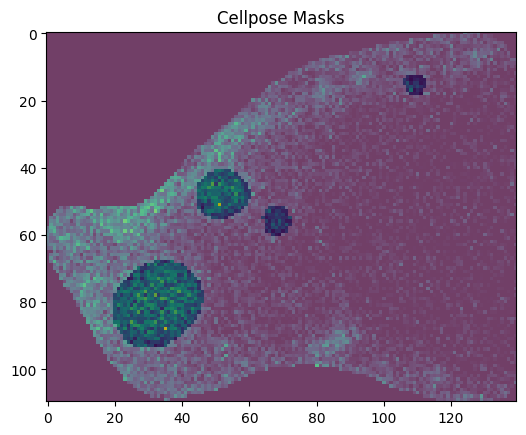

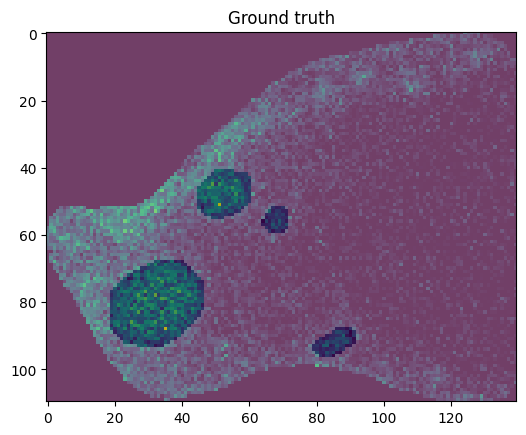

In [26]:
im = 10
fig1, ax1 = plt.subplots()
ax1.imshow(test_images[im][ :, :], vmin = 50)
ax1.imshow(retrained_masks[im], alpha = 0.25, cmap = 'inferno_r', vmax = 1)
ax1.set_title('Cellpose Masks')

fig3, ax3 = plt.subplots()
ax3.imshow(test_images[im][ :, :], vmin = 50)
ax3.imshow(ground_truth_test[im], alpha = 0.25, cmap = 'inferno_r', vmax = 1)
ax3.set_title('Ground truth')

In [ ]:
print(test_images[im].shape)
print(len(retrained_masks))
# %matplotlib
# plt.figure(figsize=(40,16))
fig, ax = plt.subplots()
ax.imshow(test_images[im][ :, :])
fig2, ax2 = plt.subplots()
ax2.imshow(retrained_masks[im], alpha = 0.25, cmap = 'inferno_r', vmax = 1)
# print(np.max(retrained_masks[2]))
